In [1]:
# import necessary library
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()

# Calculate Weekly and Monthly Total Traffic

In [3]:
# Import estimated daily Volume
DV=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Estimated_SC_DV.csv')
DV=DV.drop(['level_0','index'],axis=1)
DV.head()

,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,CH17,2019.0,E,Tuesday,3.0,89834,38.67821,-121.29246,77.418452
1,CH17,2019.0,N,Tuesday,3.0,89833,38.67821,-121.29246,55.259502
2,CH17,2019.0,S,Tuesday,3.0,89698,38.67821,-121.29246,35.149290
3,CH23,2019.0,N,Tuesday,3.0,89504,38.67837,-121.28207,34.628136
4,CH25,2019.0,S,Tuesday,3.0,bearing calculation not match with TMS count,38.67829,-121.27601,47.098246


In [4]:
# import pop, CBD and Strava
stv=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Sc_Stv_pop_CBD.csv')
stv.tail(2)

,Unnamed: 0.1,ID,year,index,Unnamed: 0,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden,Max_AMI_PMI
2128,2128,Eric_Fischer172,2016.0,2128,2052,307791126.0,13290823.0,NaN,NaN,NaN,NaN,0.0,POINT (159420.1130226079 -443267.1609445624),9.317828,21037.041013,5.730304
2129,2129,Eric_Fischer652,2016.0,2129,2081,308132385.0,578782028.0,NaN,NaN,NaN,NaN,0.0,POINT (149287.63401175514 -414268.8311619335),11.597683,2486.338522,4.006727


In [5]:
stv1=stv[['ID','year','stv_rec_ratio','CBD Distance','popden']]
stv1.shape

(2130, 5)

In [6]:
DV1=pd.merge(DV,stv1, on=['ID','year'],how='inner')
DV1.shape

(5757, 12)

In [7]:
DV['ID'].nunique(),stv['ID'].nunique(),DV1['ID'].nunique()

(2114, 2129, 2104)

In [8]:
# Now find the short term sites that did not match
common = stv.merge(DV,on=['ID', 'year'])
ch=stv[(~stv.ID.isin(common.ID))]
ch.head()

,Unnamed: 0.1,ID,year,index,Unnamed: 0,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden,Max_AMI_PMI
18,18,Kern2,2016.0,18,18,308518564.0,10412460.0,75.0,0.0,75.0,NaN,1.000000,POINT (98373.05907189 -294466.6108904835),63.198006,3819.757759,1.029077
28,28,Kern92,2016.0,28,28,308504507.0,10404232.0,60.0,15.0,45.0,NaN,0.750000,POINT (87425.40705098309 -292431.4765795502),68.987625,1730.974240,2.191929
31,31,Kern104,2016.0,31,31,308496439.0,125436414.0,875.0,70.0,805.0,NaN,0.920000,POINT (84803.04972119498 -293946.6394319497),69.587775,1972.054003,1.333801
46,46,Kern137,2016.0,46,46,308476594.0,10428508.0,65.0,15.0,50.0,NaN,0.769231,POINT (87974.35855171949 -300270.505732941),65.554941,6164.919201,2.513279
67,67,Kern1,2016.0,67,67,308518559.0,10433051.0,125.0,35.0,90.0,NaN,0.720000,POINT (97810.85951836169 -294620.5689044185),63.375901,4036.186654,2.542888


In [9]:
ch['ID'].unique()

array(['Kern2', 'Kern92', 'Kern104', 'Kern137', 'Kern1', 'SLO_Co131',
       'Vista7', 'Vista8', 'Kern350', 'Kern432', 'Kern516', 'Kern627',
       'WC6', 'LA_Intx109', 'Vista18', 'Kern504', 'Vista23', 'Vista24',
       'Vista56', 'Vista65', 'Vista22', 'Vista90', 'Miovision299',
       'Miovision358', 'Vista16'], dtype=object)

In [10]:
# Lets separate sites that have Strava RR 
DV1['popden'].isnull().sum(),DV1['CBD Distance'].isnull().sum(),DV1['stv_rec_ratio'].isnull().sum()
# it seems 13 sites hass popden missing or zero pop density and 3673  have missing SRR

(0, 0, 0)

In [11]:
DV1['popden'].fillna(1, inplace=True)

In [12]:
DV1p1=DV1.loc[DV1['stv_rec_ratio']>=0]
DV1p2=DV1[DV1['stv_rec_ratio'].isnull()]

In [13]:
DV1.shape,DV1p1.shape,DV1p2.shape 

((5757, 12), (5757, 12), (0, 12))

In [14]:
# Now estimate SRR using the formula.
# a=0.96967
# b=-0.00303
# c=0.02395
# DV1p2['stv_rec_ratio']=a+b*np.sqrt(DV1p2['popden'])+c*np.log(DV1p2['CBD Distance'])
# DV1p2.head()

In [15]:
# now combine with rest of the data that have already SRR
DV3=DV1p1
DV3.shape

(5757, 12)

In [16]:
# Now calculate the WWI index using WWI= 0.54311-0.04492* ln(population Density) + 0.60716 *〖"(Strava Recreational Ratio)" 〗^𝟐
a=0.54311
b=-0.04492
c=0.60716
DV3['WWI']=a+b*np.log(DV3['popden'])+c*np.power(DV3['stv_rec_ratio'],2)

In [17]:
# Split the data by WWI threshold to apply DOW factor
w_g1=DV3.loc[DV3['WWI']<=0.40]
w_g2=DV3.loc[DV3['WWI']>0.40]
w_g2.tail(2)

,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,CBD Distance,popden,WWI
5755,SCC73,2018.0,S,Saturday,6.0,115615,37.04393,-122.07292,36.645619,0.912883,22.770203,695.462189,0.755108
5756,SCC73,2018.0,W,Saturday,6.0,115916,37.04393,-122.07292,291.963220,0.912883,22.770203,695.462189,0.755108


In [18]:
# read DOW factor
DOW=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Final Factor/Final_DOW_Factor.csv')
DOW.head()

,Unnamed: 0,Day of Week,Average_Group_DOW_Factor,criteria
0,0,Monday,0.157551,WWI<=0.40
1,1,Tuesday,0.172370,WWI<=0.40
2,2,Wednesday,0.168847,WWI<=0.40
3,3,Thursday,0.161830,WWI<=0.40
4,4,Friday,0.145732,WWI<=0.40


In [19]:
DOW_g1=DOW.loc[DOW['criteria']=='WWI<=0.40']
DOW_g2=DOW.loc[DOW['criteria']=='WWI>0.40']

In [20]:
# Apply factor to obtain weekly Total Volume Volume
wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
wg1_DV['Weekly_Volume']=wg1_DV['TDV']/wg1_DV['Average_Group_DOW_Factor']
wg1_DV1=pd.DataFrame({'TWV' : wg1_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()
wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
wg2_DV['Weekly_Volume']=wg2_DV['TDV']/wg2_DV['Average_Group_DOW_Factor']
wg2_DV2=pd.DataFrame({'TWV' : wg2_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()


In [21]:
# combine these three group of estimated daily volume together
WV=pd.concat([wg1_DV1,wg2_DV2],axis=0).reset_index()
WV.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV
0,0,AC201610,2016.0,E,10.0,158851,37.890578,-122.293576,1107.993357
1,1,AC201610,2016.0,N,10.0,158850,37.890578,-122.293576,2457.067755
2,2,AC201610,2016.0,S,10.0,158847,37.890578,-122.293576,2705.162772
3,3,AC201610,2016.0,W,10.0,158849,37.890578,-122.293576,1026.026503
4,4,AC201623,2016.0,E,11.0,155231,37.576880,-122.027060,622.535719


In [22]:
WV['ID'].nunique()

2104

In [23]:
# Now divide TWV by 7 to get the weekley average volume
WV['AWV']=WV['TWV']/7
WV['year'] = WV['year'].apply(np.int64)
WV['month'] = WV['month'].apply(np.int64)
WV.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV
0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1107.993357,158.284765
1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2457.067755,351.009679
2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2705.162772,386.451825
3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1026.026503,146.575215
4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,622.535719,88.933674


In [24]:
# Now calculate the number of days in data collection month and multiple average weekly volume (AWV) to get monthly total volume
# create dummy day column to get the date and days in month
WV['day']=1
cols=["year","month","day"]
WV['date'] = WV[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
WV['date'] = pd.to_datetime(WV['date'], errors='coerce')
WV['days_in_month'] = WV['date'].dt.days_in_month
WV.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month
0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1107.993357,158.284765,1,2016-10-01,31
1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2457.067755,351.009679,1,2016-10-01,31
2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2705.162772,386.451825,1,2016-10-01,31
3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1026.026503,146.575215,1,2016-10-01,31
4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,622.535719,88.933674,1,2016-11-01,30


In [25]:
WV['MTT']=WV['AWV']*WV['days_in_month']
WV['MTT'].describe()

count      5618.000000
mean       5102.835838
std        8690.592219
min           0.000000
25%        1088.066246
50%        2530.549888
75%        5706.782511
max      241115.345801
Name: MTT, dtype: float64

<AxesSubplot:>

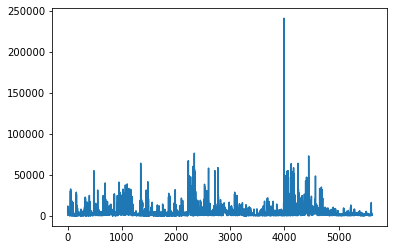

In [26]:
WV['MTT'].plot()

# Now Estimate Annual Total Traffic

In [27]:
# read the moy factor
MOY=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Final Factor/Final_MOY_Factor.csv')
MOY.head()

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
0,0,1,0.067350,seasonal_factor<=2.4
1,1,2,0.070993,seasonal_factor<=2.4
2,2,3,0.080101,seasonal_factor<=2.4
3,3,4,0.087527,seasonal_factor<=2.4
4,4,5,0.091078,seasonal_factor<=2.4


In [28]:
MOY['Criteria'].unique()

array(['seasonal_factor<=2.4', '2.4<seasonal_factor<=5',
       'seasonal_factor>5'], dtype=object)

In [29]:
# Now split the data by group
moy_g1=MOY.loc[MOY['Criteria']=='seasonal_factor<=2.4']
moy_g2=MOY.loc[MOY['Criteria']=='2.4<seasonal_factor<=5']
moy_g3=MOY.loc[MOY['Criteria']=='seasonal_factor>5']
moy_g3.head(2)

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
24,0,1,0.021449,seasonal_factor>5
25,1,2,0.018644,seasonal_factor>5


In [30]:
# Calculate the seasonality factor and check how many sites have data to calculate it
# get June/July/August Data
dos678=DV[(DV['month']>5) &(DV['month']<9)]
dos678=dos678[['ID','year','Leg','TDV']]
dos678c=pd.DataFrame({'Average Daily Count678' : dos678.groupby(['ID','year','Leg'])['TDV'].mean()}).reset_index()
dos678c.head()

,ID,year,Leg,Average Daily Count678
0,CH32,2019.0,S,20.231538
1,Eric_Fischer1007,2016.0,E,25.279441
2,Eric_Fischer1007,2016.0,N,37.919161
3,Eric_Fischer1007,2016.0,S,37.919161
4,Eric_Fischer1028,2016.0,E,218.618147


In [31]:
# get December/January/February Data
dos12=DV.loc[DV['month']==12]
dos1=DV.loc[DV['month']==1]
dos3=DV.loc[DV['month']==2]
dos1213=pd.concat([dos12,dos1,dos3],axis=0)
dos1213=dos1213[['ID','year',"Leg",'TDV']]
dos12131=pd.DataFrame({'Average Daily Count12131' : dos1213.groupby(['ID','year','Leg'])['TDV'].mean()}).reset_index()
dos12131.head()

,ID,year,Leg,Average Daily Count12131
0,AC201648,2016.0,E,84.617767
1,AC201648,2016.0,N,13.220884
2,AC201648,2016.0,S,0.000000
3,AC201648,2016.0,W,80.210805
4,AC201663,2016.0,E,41.371608


In [32]:
seasonal_data=pd.merge(dos12131,dos678c, left_on=['ID','year','Leg'],right_on=['ID','year','Leg'],how='inner')
seasonal_data['seasonal_factor']=seasonal_data['Average Daily Count678']/seasonal_data['Average Daily Count12131']
seasonal_data=seasonal_data[['ID','year','Leg','seasonal_factor']]
seasonal_data.head()

,ID,year,Leg,seasonal_factor


In [33]:
# It seems none of the sites have data to calculate the seasonality, therefore used geohrahic classification to assign the
#seasonality group. Use the closest distance to assign the seasonal group
g1=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Revised_Seasonality/Group1.shp')
g1['group']='seasonal_factor<=2.4'
g2=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Revised_Seasonality/Group2.shp')
g2['group']='2.4<seasonal_factor<=5'
g3=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Revised_Seasonality/Group3.shp')
g3['group']='seasonal_factor>5'
# combine all
s_g=pd.concat([g1,g2,g3],axis=0)
#s_g['group'] = s_g['group'].apply(np.int64)
s_g.head()

,Field1,ID,latitude,longitude,location,road,city,county,state,country,Average_se,geometry,group
0,0,671,37.791160,-122.459440,urban,Bay Area Ridge Trail,San Francisco,None,California,United States,1.268874,POINT (-122.45944 37.79116),seasonal_factor<=2.4
1,1,1127,37.796165,-122.419490,urban,Broadway,San Francisco,None,California,United States,1.012863,POINT (-122.41949 37.79617),seasonal_factor<=2.4
2,2,2415,37.774200,-122.436295,urban,Fell Street,San Francisco,None,California,United States,1.407406,POINT (-122.43629 37.77420),seasonal_factor<=2.4
3,3,2694,33.683254,-117.662080,urban,Torino Drive,None,Orange County,California,United States,1.359999,POINT (-117.66208 33.68325),seasonal_factor<=2.4
4,4,2695,33.672590,-117.651860,urban,Serrano Road,None,Orange County,California,United States,1.515797,POINT (-117.65186 33.67259),seasonal_factor<=2.4


In [34]:
s_g.groupby(['group'])['ID'].count()

group
2.4<seasonal_factor<=5      6
seasonal_factor<=2.4      152
seasonal_factor>5           6
Name: ID, dtype: int64

In [36]:
s_g.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
WV1 = gpd.GeoDataFrame(WV, geometry=gpd.points_from_xy(WV.Long, WV.Lat))
WV1.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1107.993357,158.284765,1,2016-10-01,31,4906.827725,POINT (-122.29358 37.89058)
1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2457.067755,351.009679,1,2016-10-01,31,10881.300057,POINT (-122.29358 37.89058)
2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2705.162772,386.451825,1,2016-10-01,31,11980.006561,POINT (-122.29358 37.89058)
3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1026.026503,146.575215,1,2016-10-01,31,4543.831654,POINT (-122.29358 37.89058)
4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,622.535719,88.933674,1,2016-11-01,30,2668.010225,POINT (-122.02706 37.57688)


In [38]:
crs = {'init': 'epsg:4326'}
WV2 = gpd.GeoDataFrame(WV1, crs=crs, geometry = 'geometry')
WV2.head()

C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1107.993357,158.284765,1,2016-10-01,31,4906.827725,POINT (-122.29358 37.89058)
1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2457.067755,351.009679,1,2016-10-01,31,10881.300057,POINT (-122.29358 37.89058)
2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2705.162772,386.451825,1,2016-10-01,31,11980.006561,POINT (-122.29358 37.89058)
3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1026.026503,146.575215,1,2016-10-01,31,4543.831654,POINT (-122.29358 37.89058)
4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,622.535719,88.933674,1,2016-11-01,30,2668.010225,POINT (-122.02706 37.57688)


In [39]:
# project the co-ordinate
WV2_proj = WV2.to_crs(epsg=3310).reset_index()
s_g_proj = s_g.to_crs(epsg=3310).reset_index()

In [40]:
def nearest_point(point, point2):
    idx = point2.geometry.distance(point).idxmin()
    return point2.loc[idx,'group']

In [41]:
WV2_proj['group'] = WV2_proj.geometry.apply(nearest_point, point2=s_g_proj)
WV2_proj.head()

,level_0,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
0,0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1107.993357,158.284765,1,2016-10-01,31,4906.827725,POINT (-201416.616 -11547.151),seasonal_factor<=2.4
1,1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2457.067755,351.009679,1,2016-10-01,31,10881.300057,POINT (-201416.616 -11547.151),seasonal_factor<=2.4
2,2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2705.162772,386.451825,1,2016-10-01,31,11980.006561,POINT (-201416.616 -11547.151),seasonal_factor<=2.4
3,3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1026.026503,146.575215,1,2016-10-01,31,4543.831654,POINT (-201416.616 -11547.151),seasonal_factor<=2.4
4,4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,622.535719,88.933674,1,2016-11-01,30,2668.010225,POINT (-178761.010 -46945.065),seasonal_factor<=2.4


In [42]:
# Now split the data by group
m_g1=WV2_proj.loc[WV2_proj['group']=='seasonal_factor<=2.4']
m_g2=WV2_proj.loc[WV2_proj['group']=='2.4<seasonal_factor<=5']
m_g3=WV2_proj.loc[WV2_proj['group']=='seasonal_factor>5']
m_g3.head(2)

,level_0,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
892,892,892,Miovision440,2016,E,6,18189,37.369464,-118.39527,141.281363,20.183052,1,2016-06-01,30,605.491555,POINT (141911.326 -70712.549),seasonal_factor>5
893,893,893,Miovision440,2016,N,6,18180,37.369464,-118.39527,461.854021,65.979146,1,2016-06-01,30,1979.374374,POINT (141911.326 -70712.549),seasonal_factor>5


In [43]:
# Now apply the MOY factor to get ATT
# Apply factor to obtain daily Volume
mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
mg1_DV['Annual_Volume']=mg1_DV['MTT']/mg1_DV['Average_Group_MOY_Factor']
mg1_DV1=pd.DataFrame({'ATT' : mg1_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
mg2_DV['Annual_Volume']=mg2_DV['MTT']/mg2_DV['Average_Group_MOY_Factor']
mg2_DV2=pd.DataFrame({'ATT' : mg2_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
mg3_DV['Annual_Volume']=mg3_DV['MTT']/mg3_DV['Average_Group_MOY_Factor']
mg3_DV3=pd.DataFrame({'ATT' : mg3_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
mg3_DV3.head()

,ID,year,Leg,matched_seg_id,Lat,Long,ATT
0,Miovision10,2018,E,2186,39.775318,-121.871931,202230.215266
1,Miovision10,2018,N,2183,39.775318,-121.871931,114572.246335
2,Miovision10,2018,W,2185,39.775318,-121.871931,140641.682462
3,Miovision102,2018,E,80658,39.171286,-120.140659,54722.681320
4,Miovision102,2018,W,80632,39.171286,-120.140659,46166.923312


In [44]:
# combine these three group of estimated Annual volume together
AV=pd.concat([mg1_DV1,mg2_DV2,mg3_DV3],axis=0).reset_index()
AV.ATT = AV.ATT.round()
AV.shape

(5615, 8)

In [45]:
AV=AV.loc[AV['Lat']!=0]
AV.head()

,index,ID,year,Leg,matched_seg_id,Lat,Long,ATT
0,0,AC20160,2016,E,155482,37.695501,-122.073977,49199.0
1,1,AC20160,2016,N,155481,37.695501,-122.073977,21807.0
2,2,AC20160,2016,S,155480,37.695501,-122.073977,25096.0
3,3,AC20160,2016,W,155626,37.695501,-122.073977,57147.0
4,4,AC20161,2016,E,151225,37.700510,-122.108190,2387.0


In [46]:
AV['Long'].isnull().sum()

0

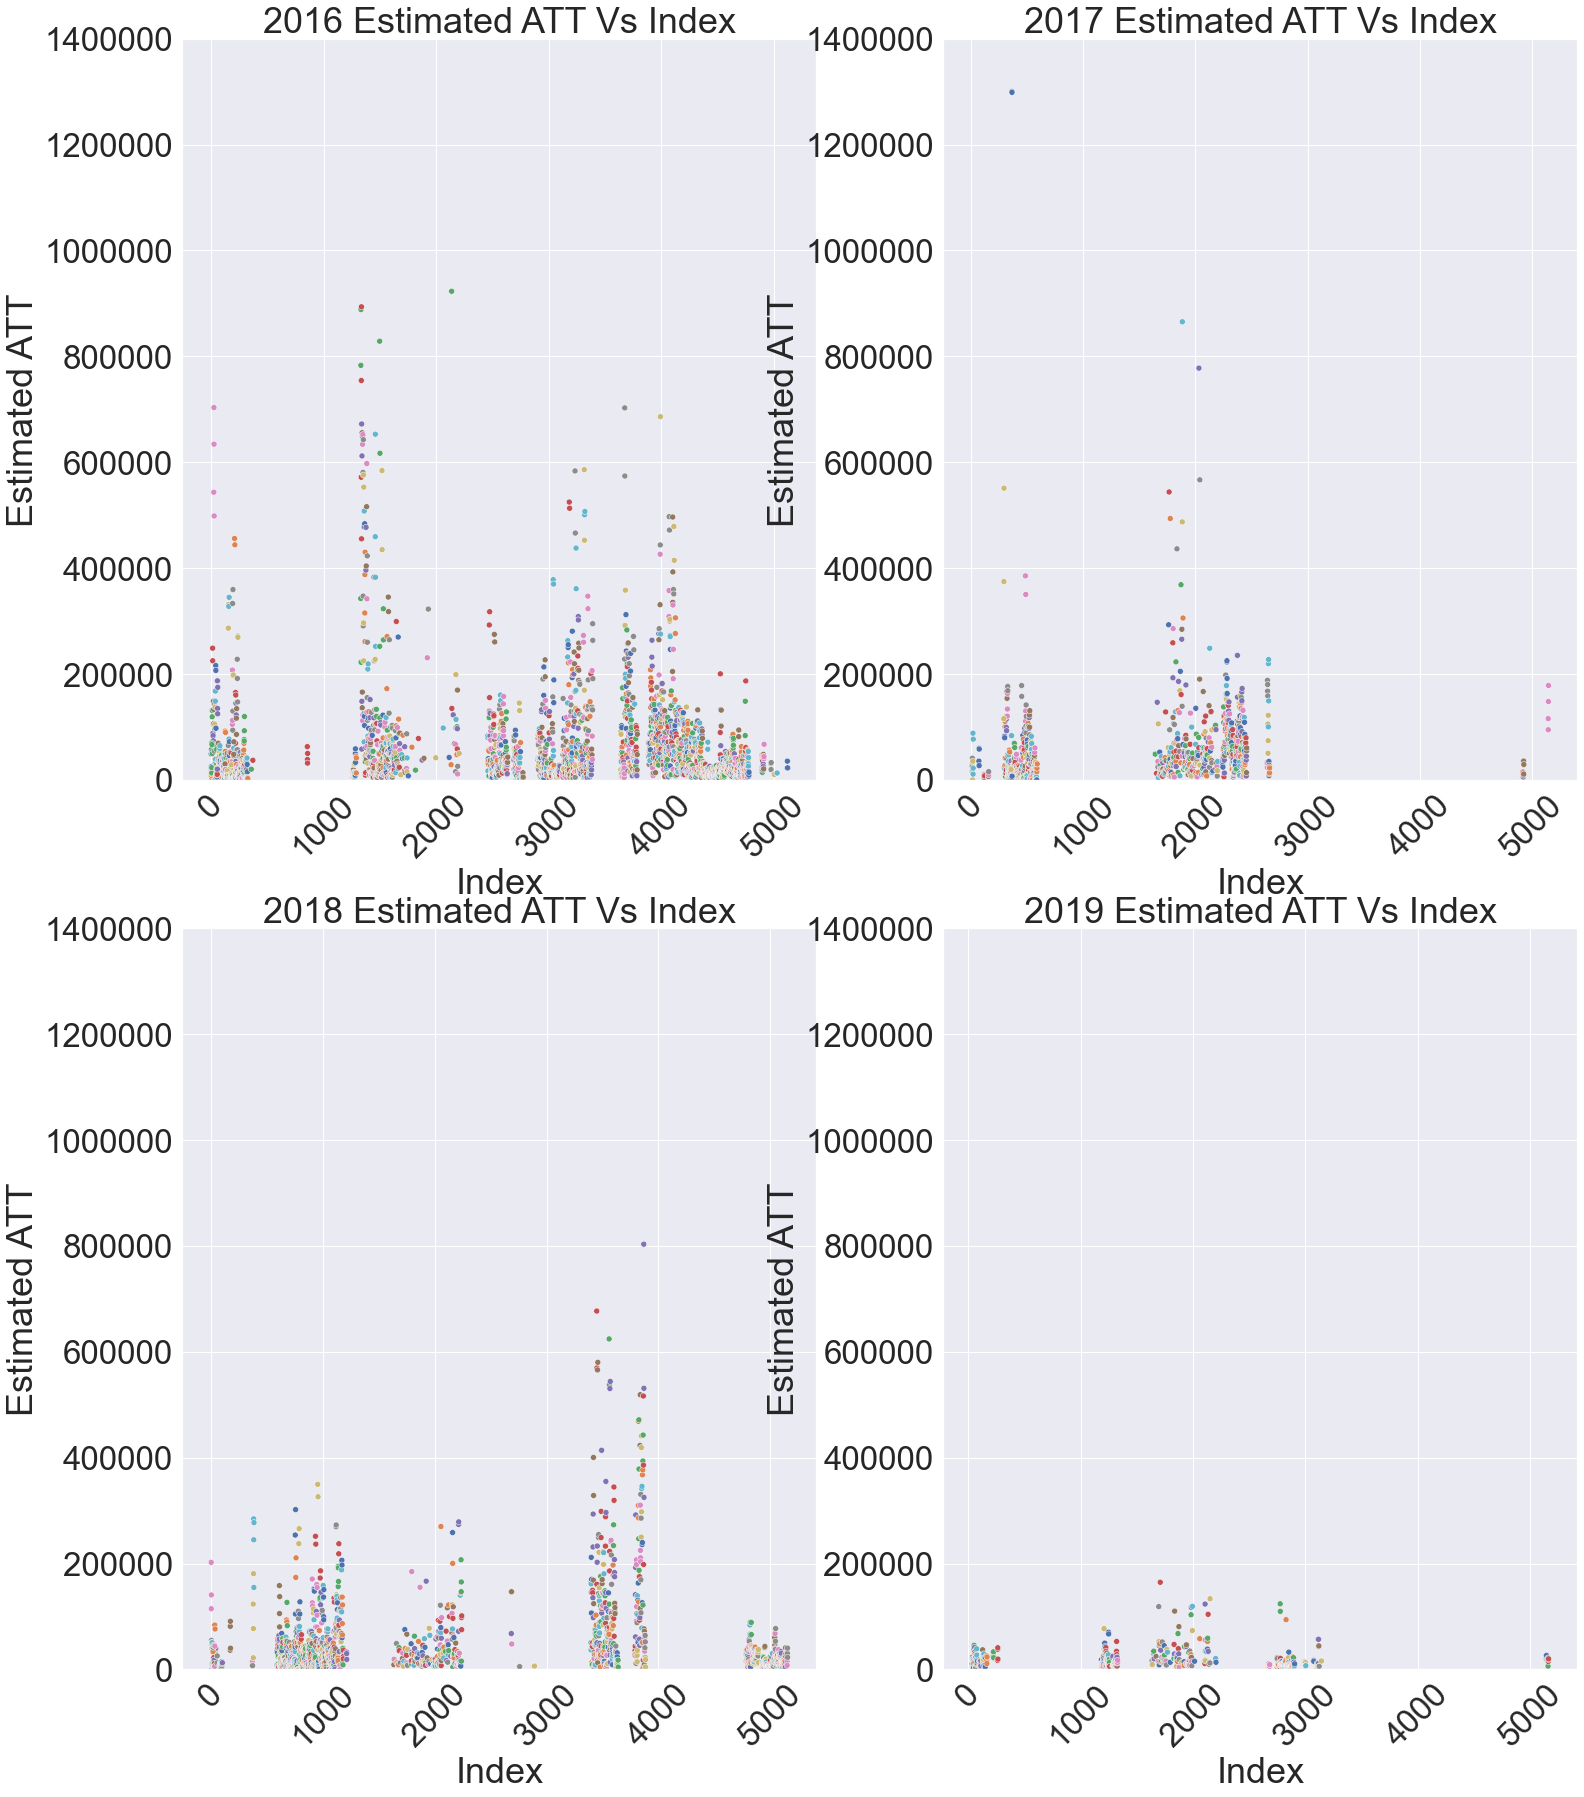

In [61]:
sns.set(rc={'figure.figsize':(25,30)})
sns.set(font_scale=3.0)
import seaborn as sns
d16=AV.loc[AV['year']==2016]
d17=AV.loc[AV['year']==2017]
d18=AV.loc[AV['year']==2018]
d19=AV.loc[AV['year']==2019]
fig, ax = plt.subplots(2,2)    
ax1 = sns.scatterplot(x=d16['index'],y=d16['ATT'],hue=d16['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.scatterplot(x=d17['index'],y=d17['ATT'],hue=d17['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.scatterplot(x=d18['index'],y=d18['ATT'],hue=d18['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[1,0])
plt.xticks(rotation = 'vertical')
ax4 = sns.scatterplot(x=d19['index'],y=d19['ATT'],hue=d19['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[1,1]) 
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax1.set_ylim([0, 1400000])
ax2.set_ylim([0, 1400000])
ax3.set_ylim([0, 1400000])
ax4.set_ylim([0, 1400000])
ax1.ticklabel_format(style='plain', axis='both')
ax2.ticklabel_format(style='plain', axis='both')
ax3.ticklabel_format(style='plain', axis='both')
ax4.ticklabel_format(style='plain', axis='both')
ax1.title.set_text('2016 Estimated ATT Vs Index')
ax2.title.set_text('2017 Estimated ATT Vs Index')
ax3.title.set_text('2018 Estimated ATT Vs Index')
ax4.title.set_text('2019 Estimated ATT Vs Index')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
ax1.set_ylabel('Estimated ATT' )
ax1.set_xlabel('Index')
ax2.set_ylabel('Estimated ATT' )
ax2.set_xlabel('Index')
ax3.set_ylabel('Estimated ATT' )
ax3.set_xlabel('Index')
ax4.set_ylabel('Estimated ATT' )
ax4.set_xlabel('Index')
plt.show()

In [48]:
AV.groupby(['year'])['Leg'].count()

year
2016    2670
2017     855
2018    1566
2019     508
Name: Leg, dtype: int64

In [49]:
AV.groupby(['year','Leg'])['ATT'].describe()

count          mean            std     min       25%      50%  \
year Leg                                                                      
2016 E        640.0  65794.848437  107527.230501     0.0  14333.00  29195.5   
     N        651.0  64404.443932   94279.350818     0.0  13596.00  35374.0   
     S        634.0  65473.001577   95496.895842     0.0  13143.25  36257.0   
     W        613.0  66071.429038  104471.088259     0.0  13214.00  29014.0   
     unknown  132.0  94688.015152   91656.774606  5627.0  40683.75  76937.0   
2017 E        198.0  64421.843434   92331.176574     0.0  15701.25  37560.5   
     N        232.0  60410.469828  112637.471414     0.0  14140.00  33459.5   
     S        217.0  61583.059908  107463.909417     0.0  12713.00  33388.0   
     W        204.0  60552.299020   70681.476551     0.0  18150.75  36508.5   
     unknown    4.0   9471.000000    4324.749935  6095.0   6448.25   8150.5   
2018 E        391.0  59827.483376   88041.979922     0.0  13321.00  30012.0   
     N        401.0  57000.029925   87277.461494     0.0  10786.00  25645.0   
     S        399.0  51407.315789   74662.968864     0.0  10860.50  23708.0   
     W        372.0  59183.013441   87732.773854     0.0  12135.25  30029.5   
     unknown    3.0  27597.666667   20395.976817  4060.0  21367.00  38674.0   
2019 E        132.0  21137.583333   22222.447064  3499.0   8443.25  13936.5   
     N        112.0  16256.375000   19082.391226  2114.0   6498.75  10384.5   
     S        118.0  18160.364407   19852.681170  2398.0   7381.25  11746.0   
     W        130.0  20328.076923   20959.980469  2481.0   7986.25  13150.5   
     unknown   16.0  10726.625000    6690.728459  4228.0   6658.75   9788.5   

                    75%        max  
year Leg                            
2016 E         62760.75   828522.0  
     N         78164.00   782867.0  
     S         80965.00   922860.0  
     W         66789.00   652050.0  
     unknown  119741.50   685950.0  
2017 E         81152.50   777674.0  
     N         71029.25  1299972.0  
     S         79441.00  1298527.0  
     W         77155.50   493674.0  
     unknown   11173.25    15488.0  
2018 E         67161.50   676805.0  
     N         57650.00   803095.0  
     S         51029.00   530924.0  
     W         64626.75   579932.0  
     unknown   39366.50    40059.0  
2019 E         23426.00   133539.0  
     N         18195.00   123917.0  
     S         19982.50   123396.0  
     W         23272.50   164556.0  
     unknown   11963.25    32643.0

In [50]:
AV.groupby(['year'])['ID'].count()

year
2016    2670
2017     855
2018    1566
2019     508
Name: ID, dtype: int64

In [51]:
AV.groupby(['year'])['ID'].nunique()

year
2016    894
2017    401
2018    550
2019    254
Name: ID, dtype: int64

In [52]:
AV['ID'].nunique()

2099

In [53]:
# Save the estimation
AV.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Estimated_SC_ATT.csv',index=False)